# Loading and Prepprocessing MNIST Data


In [1]:
#importing the necessary libraries for this assesment
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random

import matplotlib.pyplot as plt

In [2]:
#loading the MNIST Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [4]:
#Preprocessing the data
img_rows, img_cols, channels = 28, 28, 1 
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


# Creating and Training the DNN Model

In [5]:
#Building the DNN Model with 3 Con2d Layers havin relu activation and final dense layer having softmax activation
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
#Compiling the model with Adam Optimizer and MSE Loss
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

In [6]:
#Building and Analyzing the Model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2

In [7]:
#Training the model over a clean dataset
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0197 - accuracy: 0.8641 - val_loss: 0.0061 - val_accuracy: 0.9586
Epoch 2/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0088 - accuracy: 0.9433 - val_loss: 0.0051 - val_accuracy: 0.9661
Epoch 3/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0074 - accuracy: 0.9525 - val_loss: 0.0043 - val_accuracy: 0.9716
Epoch 4/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0065 - accuracy: 0.9588 - val_loss: 0.0042 - val_accuracy: 0.9729
Epoch 5/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0061 - accuracy: 0.9610 - val_loss: 0.0041 - val_accuracy: 0.9728
Epoch 6/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0055 - accuracy: 0.9651 - val_loss: 0.0038 - val_accuracy: 0.9746
Epoch 7/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0051 - accuracy: 0.9668 - val_loss: 0.0033 - val_ac

In [8]:
print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Base accuracy on regular images: [0.0030932831577956676, 0.9818000197410583]


# Untargeted FGSM Attack

In [9]:
#Using the equation from the slides and building pertrubed images
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [10]:
#Generating the pertrubed images and labeling them
def generate_adversarials(batch_size,epsilon):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_test[N]
            image = x_test[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_test[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

In [11]:
#Running the adversarial pertrubations using different epsilon values and recording the number of images correctly classified after the attack
epsilon = [1,5,10,20,30,40,50]
accuracyuntargeted = np.zeros(shape=(len(epsilon)))
for i in range(len(epsilon)):
  adversarials, correct_labels = next(generate_adversarials(10000,epsilon[i]))
  accuracy = 0
  for adversarial, correct_label in zip(adversarials, correct_labels):
    if labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()] == labels[correct_label.argmax()]:
      accuracy = accuracy+1
    else:
      accuracy = accuracy+0
  testacc = accuracy/10000
  accuracyuntargeted[i] = testacc
  print("epsilon,accuracy",epsilon[i],testacc)

print(accuracyuntargeted)

epsilon,accuracy 1 0.0299
epsilon,accuracy 5 0.0498
epsilon,accuracy 10 0.0517
epsilon,accuracy 20 0.0483
epsilon,accuracy 30 0.0528
epsilon,accuracy 40 0.0502
epsilon,accuracy 50 0.0466
[0.0299 0.0498 0.0517 0.0483 0.0528 0.0502 0.0466]


# Targeted FGSM Attacks

In [12]:
#Changing the loss function so that it fooled to classify the image to target label
def adversarial_pattern_Targeted(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = -1*tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [13]:
#Changing value of y to the target label
def generate_adversarials_Targeted(batch_size,epsilon):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)
            target_label = (y_test[N]+1)%10
            label = target_label
            image = x_test[N]
            
            perturbations = adversarial_pattern_Targeted(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(target_label)
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

In [14]:
#Conducting the attack over the different epsilons
accuracytargeted = np.zeros(shape=(len(epsilon)))
for i in range(len(epsilon)):
  adversarials, correct_labels = next(generate_adversarials_Targeted(10000,epsilon[i]))
  accuracy = 0
  for adversarial, correct_label in zip(adversarials, correct_labels):#predictedlabel needs to change to targetedlabel
    if labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()] == labels[correct_label.argmax()]:
      accuracy = accuracy+1
    else:
      accuracy = accuracy+0
  testacc = accuracy/10000
  accuracytargeted[i]=testacc
  print("epsilon,accuracy",epsilon[i],testacc)

print(accuracytargeted)

epsilon,accuracy 1 0.7494
epsilon,accuracy 5 0.7095
epsilon,accuracy 10 0.7249
epsilon,accuracy 20 0.7215
epsilon,accuracy 30 0.7112
epsilon,accuracy 40 0.7036
epsilon,accuracy 50 0.7178
[0.7494 0.7095 0.7249 0.7215 0.7112 0.7036 0.7178]


# Adversarial Retraining against Untargeted FGSM Attacks

In [15]:
#Generating adversarial images from the train set so that we can retrain our network
def generate_adversarials_on_Train(batch_size,epsilon):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

In [16]:
# Generate adversarial data on the train and test set

x_adversarial_train, y_adversarial_train = next(generate_adversarials_on_Train(60000,10))
x_adversarial_test, y_adversarial_test = next(generate_adversarials_on_Train(10000,10))

In [17]:
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [0.1896578073501587, 0.04879999905824661]


In [18]:
# Retraining the model with the pertrubed images
model.fit(x_adversarial_train, y_adversarial_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.1716 - accuracy: 0.1420 - val_loss: 0.0684 - val_accuracy: 0.6344
Epoch 2/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1469 - accuracy: 0.2651 - val_loss: 0.1088 - val_accuracy: 0.4228
Epoch 3/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1364 - accuracy: 0.3177 - val_loss: 0.1465 - val_accuracy: 0.2385
Epoch 4/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1286 - accuracy: 0.3568 - val_loss: 0.1304 - val_accuracy: 0.3070
Epoch 5/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1228 - accuracy: 0.3860 - val_loss: 0.1648 - val_accuracy: 0.1521
Epoch 6/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1224 - accuracy: 0.3880 - val_loss: 0.1475 - val_accuracy: 0.2176
Epoch 7/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1224 - accuracy: 0.3877 - val_loss: 0.1674 - val_ac

In [19]:

print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))
evaluation = model.evaluate(x=x_test, y=y_test, verbose=0)
print("Defended accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Defended accuracy on adversarial images: [0.11989998817443848, 0.40049999952316284]
Defended accuracy on regular images: [0.16326840221881866, 0.17560000717639923]


In [20]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials_on_Train(10000,10))
print("Defended accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Defended accuracy on adversarial images: [0.16830001771450043, 0.15850000083446503]


# Answers

Epsilon vs Accuracy for Untargeted and Targeted FGSM Attacks

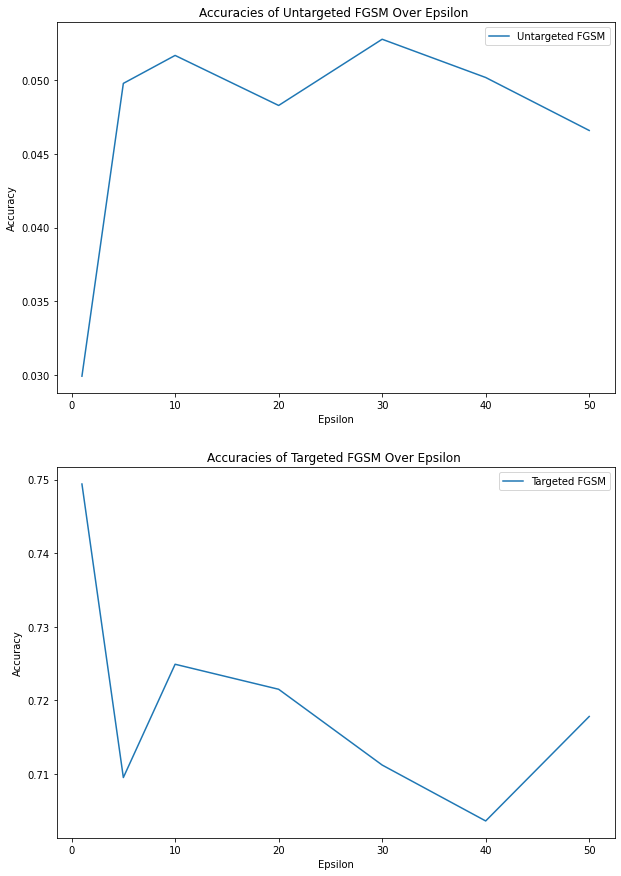

In [21]:
plt.figure(figsize = (10,15))
plt.subplot(2, 1, 1)
plt.plot(epsilon, accuracyuntargeted, label = "Untargeted FGSM")
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracies of Untargeted FGSM Over Epsilon ')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(epsilon, accuracytargeted, label = "Targeted FGSM")
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracies of Targeted FGSM Over Epsilon ')
plt.legend()
plt.show() 

The adversarily retrained network is not robust against the attack and the success rate is :

In [22]:
print(evaluation)

[0.16326840221881866, 0.17560000717639923]


# References

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb#scrollTo=h3IKyzTCDNGo

https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/adversarial_fgsm.ipynb

https://medium.com/analytics-vidhya/implementing-adversarial-attacks-and-defenses-in-keras-tensorflow-2-0-cab6120c5715

https://github.com/soumyac1999/FGSM-Keras

https://github.com/EvolvedSquid/tutorials/blob/master/adversarial-attacks-defenses/adversarial-tutorial.ipynb

https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php